In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [4]:
df = pd.read_csv("../data/processed/final_training_data.csv")

# Quick look
df.head()

# Basic info
df.info()

# Check for nulls
df.isnull().sum()

/var/folders/px/j7p2_nnn6h339lc16xg05qbw0000gn/T/ipykernel_9886/2739705867.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/final_training_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528625 entries, 0 to 528624
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   requestid            528625 non-null  int64  
 1   boro                 528625 non-null  object 
 2   year                 528625 non-null  int64  
 3   month                528625 non-null  int64  
 4   day                  528625 non-null  int64  
 5   hour                 528625 non-null  int64  
 6   minute               528625 non-null  int64  
 7   vol                  528625 non-null  int64  
 8   segmentid            528625 non-null  int64  
 9   wktgeom              528625 non-null  object 
 10  street               528625 non-null  object 
 11  fromst               528625 non-null  object 
 12  tost                 528625 non-null  object 
 13  direction            528625 non-null  object 
 14  timestamp            528625 non-null  object 
 15  dayofweek        

requestid                   0
boro                        0
year                        0
month                       0
day                         0
hour                        0
minute                      0
vol                         0
segmentid                   0
wktgeom                     0
street                      0
fromst                      0
tost                        0
direction                   0
timestamp                   0
dayofweek                   0
is_weekend                  0
is_rush_hour                0
is_holiday                  0
holiday_name           510289
holiday_type           510289
is_holiday_period           0
temperature_2m              0
precipitation               0
weathercode                 0
windspeed_10m               0
weather_description         0
dtype: int64

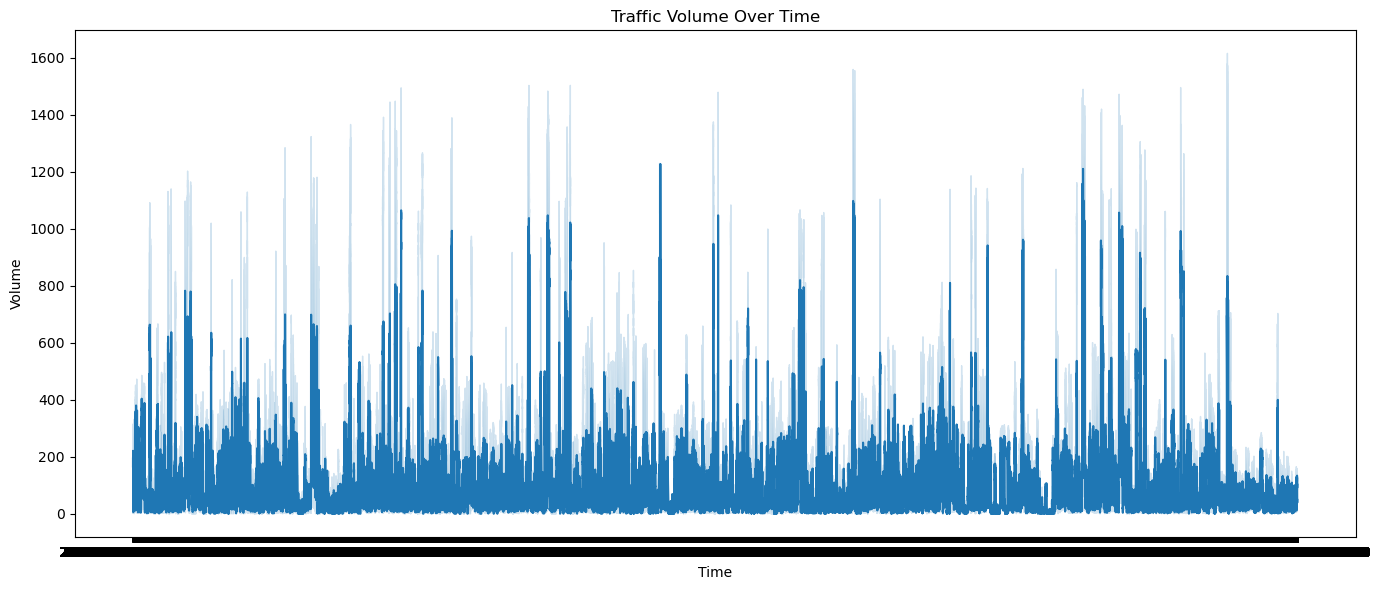

In [28]:
# Line Plot: Volume Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='timestamp', y='vol')
plt.title("Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

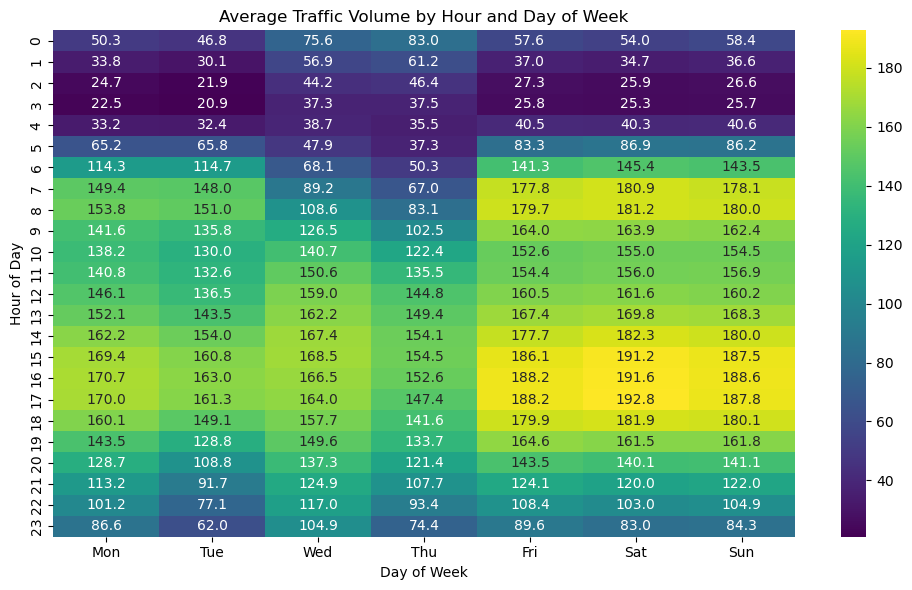

In [29]:
# Heatmap: Hour vs Day of Week

# Pivot table: rows=hour, columns=dayofweek, values=mean volume
pivot = df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')

# Rename columns from 0–6 to weekday names
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

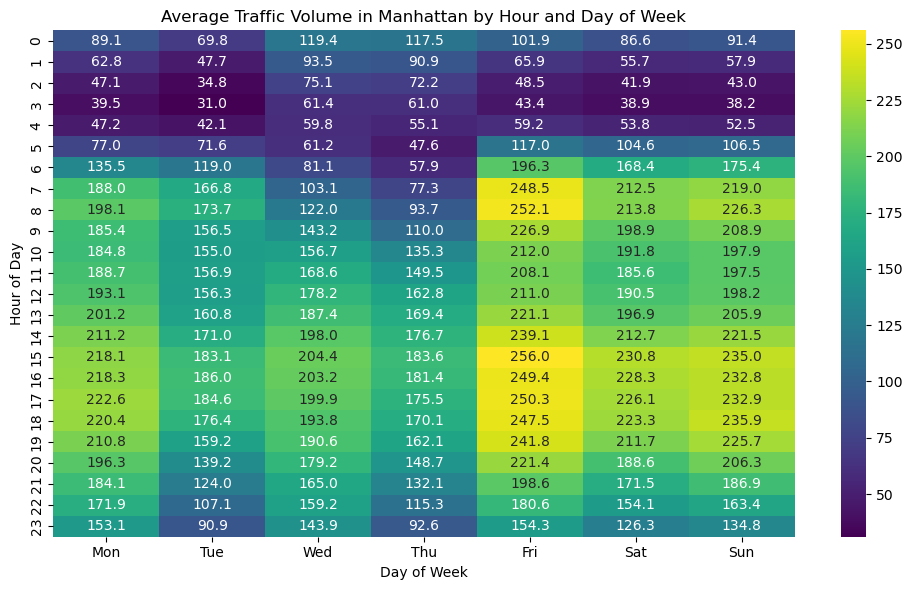

In [30]:
# Heatmap by bourough (ex. Manhattan)
manhattan_df = df[df['boro'] == 'Manhattan']

# Then pivot just like before
pivot = manhattan_df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume in Manhattan by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

In [1]:
# Define features and target
target = 'vol'
numerical_features = [
    'year', 'month', 'day', 'hour', 'minute', 
    'temperature_2m', 'precipitation', 'windspeed_10m'
]
categorical_features = [
    'boro', 'dayofweek', 'is_weekend', 'is_rush_hour', 
    'is_holiday', 'weather_description', 'direction'
]

In [5]:
# For now, exclude spatial features and segmentid for prediction
# (we'll use segmentid for grouping or route optimization later)
features = numerical_features + categorical_features

# Split data into features (X) and target (y)
X = df[features]
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define Random Forest model pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [7]:
# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(root_mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

In [ ]:
# Evaluate model performance

print("Random Forest Performance:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

Random Forest Performance:
MAE: 12.74
RMSE: 4.93
R²: 0.98


KeyboardInterrupt: 

In [ ]:
# Determining the significance of MAE

# Calculate mean and standard deviation of vol
mean_vol = df['vol'].mean()
std_vol = df['vol'].std()

# Your model's MAE
mae = 12.74

# Calculate relative MAE
relative_mae = (mae / mean_vol) * 100

print(f"Mean vol: {mean_vol:.2f} vehicles")
print(f"Standard deviation of vol: {std_vol:.2f} vehicles")
print(f"MAE: {mae:.2f} vehicles")
print(f"Relative MAE: {relative_mae:.2%}")

In [ ]:
# Perform 5-fold cross-validation
cv_scores_rf = cross_val_score(rf_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE (Random Forest): {-cv_scores_rf.mean():.2f} +- {cv_scores_rf.std():.2f}")